In [1]:
import os
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#in order to use SMOTE, you've got to import Pipeline from imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import dill as pickle
import enchant
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

# Import Labeled Texts

In [2]:
def create_labeled_df(labeled_data_path):
    '''
    Create a pandas DataFrame with the labled attachment texts.
    
    Arguments:
        labeled_data_path (str): the directory for the labeled attachment text files.
        
    Returns:
        labeled_df (pandas DataFrame): a dataframe with a column for the file name, 
                                       the text, and the label (green, yellow or red).
    '''
    
    texts = []
    files = []
    labels = []
    for file in os.listdir(labeled_data_path):
        if file.startswith('.'):
            continue
        else:
            files.append(file)
            label = file.split('_')[0]
            labels.append(label)
            file_path = os.path.join(labeled_data_path,file)
            #foce utf-8, ignoring erros
            with open(file_path, 'r', errors='ignore') as f:
                text = f.read()
                texts.append(text)
    labeled_df = pd.DataFrame(data=[files,texts,labels]).transpose()
    labeled_df.columns = ['file','text','label']
    return labeled_df

In [3]:
labeled_df = create_labeled_df('labeled_fbo_docs')

In [4]:
labeled_df.head()

,file,text,label
0,RED_FA8773-10-R-0086.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSTATEMENT OF W...,RED
1,RED_NAMA-10-Q-0119.txt,\nThis is a combined synopsis/solicitation for...,RED
2,RED_EA1330-12-RQ-0249.txt,AMENDMENT OF SOLICITATION/MODIFICATION OF CONT...,RED
3,RED_FA7014-12-T-1016.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\nSAF/FMB \n\n\n\n\n...,RED
4,GREEN_1055521.txt,\n\nStatement of Work:\n\n1.0 BACKGROUND\nFD...,GREEN


In [5]:
#recode labels to numeric, making the minority Green class the positive class
labeled_df['target'] = labeled_df['label'].map({'GREEN':1,'YELLOW':0,'RED':0})

# EDA

In [6]:
labeled_df['target'].value_counts()

0    722
1    271
Name: target, dtype: int64

In [7]:
# describe the number of chars per text
labeled_df['text'].apply(lambda x: len(x)).describe().apply(lambda x: '%.f' % x)

count        993
mean      154852
std       301244
min          571
25%        32128
50%        87841
75%       191132
max      5730156
Name: text, dtype: object

Some docs have a whole bunch of text, most of which is probably useless. Let's count the number of tokens per doc:

In [8]:
# describe the number of unique tokens per doc
labeled_df['text'].apply(lambda x: len(set(x.split()))).describe().apply(lambda x: '%.f' % x)

count      993
mean      3830
std       3637
min         58
25%       1433
50%       3098
75%       5356
max      49024
Name: text, dtype: object

One doc has 49,024 unqiue words. That's insane and will make our feature matrix super sparse, leading to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

# Normalize Text

In [9]:
stop_words = set(stopwords.words('english'))
no_nonsense_re = re.compile(r'(^[a-zA-Z]+$)|(^(508)+$)|(^(70)+$)|(^(1194)+$)|(^(1973)+$)')
def strip_nonsense(doc):
    """
    Returns stemmed lowercased tokens (using whitespace to tokenize) from a doc 
    so long as the token was in the enchant dict.
    
    Parameters:
        doc (str): the text of a single FBO document.
        
    Returns:
        words (str): a space-delimited string of lower-case chars
    """
    porter = PorterStemmer()
    d = enchant.Dict("en_US")
    for w in {'508', '70', '1194', '1973'}:
        d.add(w)
    doc = doc.lower()
    doc_split = doc.split()
    words = ''
    for word in doc_split:
        m = re.match(no_nonsense_re, word)
        if m:
            match = m.group()
            if match in stop_words:
                continue
            else:
                match_len = len(match)
                if match_len <= 17 and match_len >= 2:
                    if d.check(match):
                        stemmed = porter.stem(match)
                        words += stemmed + ' '
    words = words.strip()
    
    return words

In [10]:
# this takes awhile, but is totally worth it
labeled_df['normalized_text'] = labeled_df['text'].apply(strip_nonsense)

In [11]:
labeled_df['normalized_text'].apply(lambda x: len(set(x.split()))).describe().apply(lambda x: '%.f' % x)

count     993
mean      933
std       598
min        22
25%       503
50%       886
75%      1323
max      6244
Name: normalized_text, dtype: object

In [12]:
(3830 - 933)/3830

0.756396866840731

That reduced sparsity by about 76%

# Feature Inspection
Here we'll calculate the 'greeness' of each token.

In [13]:
# create separate DataFrames for ham and spam
green = labeled_df[labeled_df.target==0]
red = labeled_df[labeled_df.target==1]

In [14]:
# learn the vocabulary of ALL messages and save it
vect = CountVectorizer()
vect.fit(labeled_df.normalized_text)
all_tokens = vect.get_feature_names()

In [15]:
# create document-term matrices for ham and spam
green_dtm = vect.transform(green.normalized_text)
red_dtm = vect.transform(red.normalized_text)

In [16]:
# count how many times EACH token appears across ALL ham messages
green_counts = np.sum(green_dtm.toarray(), axis=0)
red_counts = np.sum(red_dtm.toarray(), axis=0)

In [17]:
# create a DataFrame of tokens with their separate ham and spam counts
token_counts = pd.DataFrame({'token':all_tokens, 'green':green_counts, 'red':red_counts})

In [18]:
# add one to ham and spam counts to avoid dividing by zero (in the step that follows)
token_counts['green'] = token_counts.green + 1
token_counts['red'] = token_counts.red + 1

In [20]:
# calculate ratio of green-to-red for each token
token_counts['green_ratio'] = token_counts.green / token_counts.red
# see top ten green tokens
token_counts.sort_values('green_ratio').sort_values(by='green_ratio', ascending=False).head(10)

,token,green,red,green_ratio
4522,freelanc,727,1,727.000000
12397,unsign,927,2,463.500000
405,amphitheat,443,1,443.000000
6284,lectur,1242,3,414.000000
878,balconi,379,1,379.000000
8698,pretrial,374,1,374.000000
1263,bonni,345,1,345.000000
6007,judiciari,297,1,297.000000
7150,morn,2032,7,290.285714
3336,dist,578,2,289.000000


Looking at the above counts bucks the notion that "keywords" such as 508 or 1194 are indicative of compliance. Although it might be better to view tf-idf scores instead of counts, it seems like there's quite a bit of noise that would introduce bias into the model, making whatever we train very overfit when attempting to look at out-of-sample docs.

Because of this, another approach might involve extracting just the 508 section out of the doc (if it has one). Doing this could prove difficult or impossible, as there's likely no standard way of identifying when such a sectin begins and/or ends.

# Helper Functions
These help visualize classification results and construct the parameter grid in the case of `log_uniform()`

In [21]:
# functions for plotting classification results
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print("="*80)
    print("Operating point = {:.3f}".format(t),end="\n\n")
    print("Confusion Matrix:")
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_red', 'pred_gree'], 
                       index=['red', 'green']),end="\n\n")
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred_adj, target_names=['red', 'green']))
    
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold",fontdict=font)
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall',fontdict=font);
    plt.ylabel('Precision',fontdict=font);
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold",fontdict=font)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score",fontdict=font)
    plt.xlabel("Decision Threshold",fontdict=font)
    plt.legend(loc='best',fontsize=16)
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
def plot_fpr_recall_vs_threshold(y_test, y_scores):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    
    
    fpr, tpr, roc_thresh = metrics.roc_curve(y_test, y_scores)
    p, r, prc_thresh = metrics.precision_recall_curve(y_test, y_scores)
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
   
    plt.figure(figsize=(8, 8))
    plt.title("False Positive and Recall Scores as a function of the decision threshold",fontdict=font)

    plt.plot(prc_thresh, r[:-1], "b--", label="Recall")
    plt.plot(roc_thresh, fpr, "g-", label="FPR")
    
    #plot vertical line where recall is highest (i.e. == 1)
    x_text = prc_thresh[0]
    plt.axvline(x=x_text)
    #plot horizontal line that will intersect where the vertical line hits the fpr line
    y_text = fpr[np.where(roc_thresh==find_nearest(roc_thresh, prc_thresh[0]))[0][0]]
    plt.axhline(y=y_text)
    x = round(x_text,2)
    y = round(y_text,2)
    plt.text(x_text,y_text,"({}, {})".format(x, y))
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best',fontsize=16)
    
def plot_prc(y_score, y_test):
    """
    Plot the precision-recall curve, labeled with average precision.
    """
    average_precision = metrics.average_precision_score(y_test, y_score)

    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    #plot it
    plt.figure(figsize=(8,8))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision),fontsize=20)

class log_uniform():        
    """
    Provides an instance of the log-uniform distribution with an .rvs() method. Meant to be used with 
    RandomizedSearchCV, particularly for params like alpha, C, gamma, etc. 
    
    Attributes:
        a (int or float): the exponent of the beginning of the range 
        b (int or float): the exponent of the end of range. 
        base (int or float): the base of the logarithm. 10 by default.
    """
    
    def __init__(self, a=-1, b=0, base=10):
        self.loc = a
        self.scale = b - a
        self.base = base

    def rvs(self, size=1, random_state=None):
        uniform = stats.uniform(loc=self.loc, scale=self.scale)
        return np.power(self.base, uniform.rvs(size=size, random_state=random_state))    
    


# Construct Grid Search Function

In [22]:
def randomized_grid_search(df, weight_classes = True, n_iter_search = 500, score='roc_auc',
                           pickle_best=True, random_state = 123, pickle_file = None):
    """
    Given labeled training data (`df`) for a binary classification task, performs a 
    randomized grid search `n_iter_search` times using SGDClassifier() and the `score`
    as a scoring metric. Prints clf report and plots roc and prc curves. Optionally pickles best classifier.
    
    Attributes:
        df (pandas DataFrame):  the training data. Currently, you must specify within the function
                                label and feature column names.
        weight_classes (bool): whether or not to use the “balanced” mode to adjust class weights.
        n_iter_search:  number of parameter settings that are sampled. Trades off runtime vs quality 
                        of the solution.
        score (str):  the scorer used to evaluate the predictions on the test set. `roc_auc` by
                      default. Available options include:  accuracy, roc_auc, precision, fbeta, recall.
                      Note: for fbeta, beta is set to 1.5 to favor recall of the positive class.
        pickle_best (bool): whether or not to pickle the best model
        random_state (123): sets the random seed for reproducibility
        pickle_path (str): what to name the pickled classifier. The scorer chosen gets appended to this name.
    """
    if weight_classes:
        clf = SGDClassifier(class_weight = 'balanced')
    else:
        clf = clf=SGDClassifier()
    
    scoring = {'accuracy': metrics.make_scorer(metrics.accuracy_score),
               'roc_auc': metrics.make_scorer(metrics.roc_auc_score),
               'precision': metrics.make_scorer(metrics.average_precision_score),
               'fbeta':metrics.make_scorer(metrics.fbeta_score,beta=.5),
               'recall':metrics.make_scorer(metrics.recall_score)}
    
    clf_name = clf.__class__.__name__
    X = df['normalized_text']
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        stratify=y,
                                                        test_size=0.2,
                                                        random_state=random_state)
    
    pipe = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
                     ('select', SelectKBest(chi2)),
                     ('clf', clf)])
    
    param_dist = {
                  "vectorizer__ngram_range":[(1,1), (1,2)],
                  "vectorizer__min_df":stats.randint(1,3),
                  "vectorizer__max_df":stats.uniform(.95,.3),
                  "vectorizer__sublinear_tf":[True, False],
                  "select__k":[10,100,200,500,1000,1500,2000,5000],
                  "clf__alpha": log_uniform(-5,2),
                  "clf__penalty": ['l2','l1','elasticnet'],
                  "clf__loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                  }
    
    random_search = RandomizedSearchCV(pipe, 
                                       param_distributions = param_dist, 
                                       scoring = scoring, 
                                       refit = score,
                                       n_iter = n_iter_search, 
                                       cv = 5,
                                       n_jobs = -1, 
                                       verbose = 1, 
                                       random_state = random_state)
    
    random_search.fit(X_train, y_train)
    
    y_pred = random_search.predict(X_test)
    #get the col number of the positive class (i.e. green)
    positive_class_col = list(random_search.classes_).index(1)
    try:
        y_score = random_search.predict_proba(X_test)[:,positive_class_col]
    except AttributeError:
        y_score = random_search.decision_function(X_test)
    average_precision = metrics.average_precision_score(y_test, y_score)
    acc = metrics.accuracy_score(y_test,y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    precisions, recalls, _ = metrics.precision_recall_curve(y_test, y_score)
    auc = metrics.auc(recalls, precisions)
    fbeta = metrics.fbeta_score(y_test,y_pred,beta=1.5)
    recall = metrics.recall_score(y_test,y_pred)

    print("\tRecall on test data:  {0:.2f}".format(recall))
    print("\tAccuracy on test data:  {0:.2f}".format(acc))
    print("\tROC-AUC on test data:  {0:.2f}".format(roc_auc))
    print("\tFbeta on test data:  {0:.2f}".format(fbeta))
    print("\tAverage Precision on test data:  {0:.2f}".format(average_precision))
    print("\tPrecision-Recall AUC on test data:  {0:.2f}".format(auc))
    print("-"*80)
    print("Classification Report:")
    class_names = ['red', 'green']
    print(metrics.classification_report(y_test, y_pred, target_names=class_names))
    print("-"*80)
    plot_prc(y_score, y_test)
    print("-"*80)
    fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_score)
    print("AUC of ROC:  {0:.4f}".format(metrics.auc(fpr, tpr)))
    plot_roc_curve(fpr, tpr, 'ROC Curve')
    best_estimator = random_search.best_estimator_
    best_score = random_search.best_score_
    result_values = [y_pred, y_score, precisions, recall, average_precision,
                     acc, roc_auc, auc, fbeta, recalls, best_score, best_estimator, y_test]
    result_keys = ['y_pred', 'y_score', 'precisions', 'recall', 'average_precision','acc',
                   'roc_auc', 'auc', 'fbeta', 'recalls','best_score','best_estimator','y_test']
    results = {k:v for k,v in zip(result_keys,result_values)}
    
    if pickle_best:
        pickle_path = os.path.join(os.getcwd(),pickle_file+score+'.pkl')
        with open(pickle_path, 'wb') as f: 
            pickle.dump(random_search.best_estimator_, f) 
    return results

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 89.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 196.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 337.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 510.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 733.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 1004.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 1026.8min finished


	Recall on test data:  0.76
	Accuracy on test data:  0.86
	ROC-AUC on test data:  0.83
	Fbeta on test data:  0.75
	Average Precision on test data:  0.80
	Precision-Recall AUC on test data:  0.80
--------------------------------------------------------------------------------
Classification Report:
             precision    recall  f1-score   support

        red       0.91      0.90      0.91       145
      green       0.75      0.76      0.75        54

avg / total       0.87      0.86      0.86       199

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
AUC of ROC:  0.9275


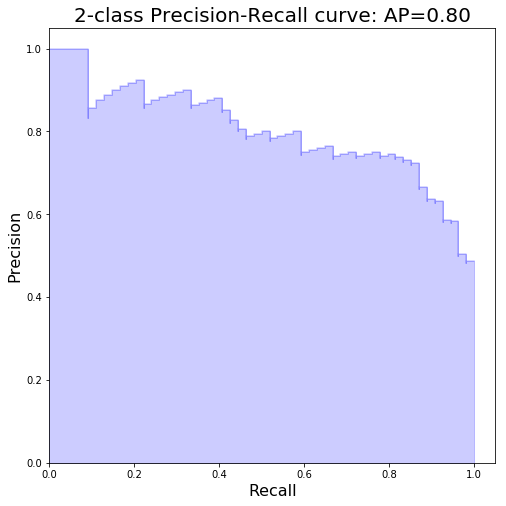

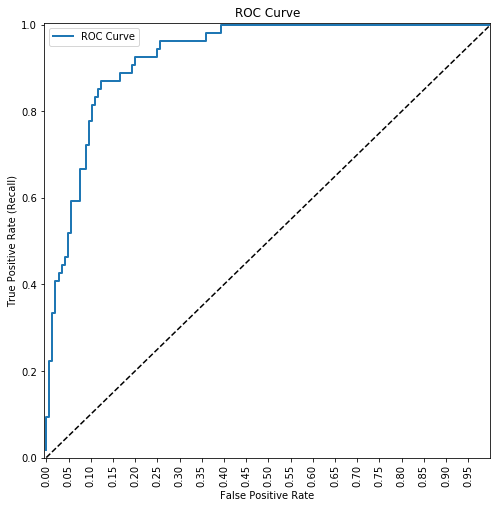

In [23]:
results = randomized_grid_search(labeled_df,
                                 n_iter_search = 500,
                                 score = 'roc_auc',
                                 pickle_best = True,
                                 random_state = 123,
                                 pickle_file = 'clf_csmcallister_pyenchat_')

# Compare against Dummy Classifiers

In [215]:
def print_dummy_clf_report(X_train, y_train, X_test, y_test):
    for strategy in ['stratified','most_frequent','prior','uniform']:
        print("="*80)
        print(strategy)
        print("="*80)
        dummy = DummyClassifier(strategy=strategy)
        dummy.fit(X_train, y_train)
        y_pred = dummy.predict(X_test)
        print(metrics.classification_report(y_test, y_pred, target_names=['red', 'green']))

In [218]:
X = np.zeros(shape=labeled_df.shape)
y = labeled_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=123)
print_dummy_clf_report(X_train, y_train, X_test, y_test)

stratified
             precision    recall  f1-score   support

        red       0.73      0.76      0.75       145
      green       0.29      0.26      0.27        54

avg / total       0.61      0.62      0.62       199

most_frequent
             precision    recall  f1-score   support

        red       0.73      1.00      0.84       145
      green       0.00      0.00      0.00        54

avg / total       0.53      0.73      0.61       199

prior
             precision    recall  f1-score   support

        red       0.73      1.00      0.84       145
      green       0.00      0.00      0.00        54

avg / total       0.53      0.73      0.61       199

uniform
             precision    recall  f1-score   support

        red       0.72      0.51      0.60       145
      green       0.26      0.46      0.33        54

avg / total       0.59      0.50      0.53       199

